<a href="https://colab.research.google.com/github/agushery/TA/blob/main/TA2_180031039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Untuk Peramalan Mobilitas Masyarakat Kota Denpasar Dengan Metode LSTM (Long Short-Term Memory)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Persiapan Library

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

## Insert Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/TA/Data-Mobilitas.csv")
# df = pd.read_csv("Data-Mobilitas.csv")

In [4]:
df.head()

,No,Tempat,9/1/2021,9/2/2021,9/3/2021,9/4/2021,9/5/2021,9/6/2021,9/7/2021,9/8/2021,9/9/2021,9/10/2021,9/11/2021,9/12/2021,9/13/2021,9/14/2021,9/15/2021,9/16/2021,9/17/2021,9/18/2021,9/19/2021,9/20/2021,9/21/2021,9/22/2021,9/23/2021,9/24/2021,9/25/2021,9/26/2021,9/27/2021,9/28/2021,9/29/2021,9/30/2021,10/1/2021,10/2/2021,10/3/2021,10/4/2021,10/5/2021,10/6/2021,10/7/2021,10/8/2021,10/9/2021,10/10/2021,10/11/2021,10/12/2021,10/13/2021,10/14/2021,10/15/2021,10/16/2021,10/17/2021,10/18/2021,10/19/2021,10/20/2021,10/21/2021,10/22/2021,10/23/2021,10/24/2021,10/25/2021,10/26/2021,10/27/2021,10/28/2021,10/29/2021,10/30/2021,10/31/2021
0,1.0,Banjar Mertanadhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,94.0,0.0,0.0,5.0,0.0,1.0,3.0,12.0,16.0,35.0,2.0,1.0,29.0,10.0,9.0,136.0,120.0,279.0,217.0,19.0,130.0,102.0,105.0,67.0,97.0,94.0,55.0,127.0,116.0,110.0,118.0,173.0,119.0,41.0,121.0,39.0,35.0,140.0,109.0,65.0,41.0,133.0,128.0,83.0,89.0,87.0,55.0,28.0
2,3.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,Politeknik Nasional Denpasar (Polnas Denpasar),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing Data

In [5]:
df.shape

(147, 63)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   No          146 non-null    float64
 1   Tempat      146 non-null    object 
 2   9/1/2021    146 non-null    float64
 3   9/2/2021    146 non-null    float64
 4   9/3/2021    146 non-null    float64
 5   9/4/2021    146 non-null    float64
 6   9/5/2021    146 non-null    float64
 7   9/6/2021    146 non-null    float64
 8   9/7/2021    146 non-null    float64
 9   9/8/2021    146 non-null    float64
 10  9/9/2021    146 non-null    float64
 11  9/10/2021   146 non-null    float64
 12  9/11/2021   146 non-null    float64
 13  9/12/2021   146 non-null    float64
 14  9/13/2021   146 non-null    float64
 15  9/14/2021   146 non-null    float64
 16  9/15/2021   146 non-null    float64
 17  9/16/2021   146 non-null    float64
 18  9/17/2021   146 non-null    float64
 19  9/18/2021   146 non-null    f

In [7]:
df.drop('No', axis=1, inplace=True)
df.head()

,Tempat,9/1/2021,9/2/2021,9/3/2021,9/4/2021,9/5/2021,9/6/2021,9/7/2021,9/8/2021,9/9/2021,9/10/2021,9/11/2021,9/12/2021,9/13/2021,9/14/2021,9/15/2021,9/16/2021,9/17/2021,9/18/2021,9/19/2021,9/20/2021,9/21/2021,9/22/2021,9/23/2021,9/24/2021,9/25/2021,9/26/2021,9/27/2021,9/28/2021,9/29/2021,9/30/2021,10/1/2021,10/2/2021,10/3/2021,10/4/2021,10/5/2021,10/6/2021,10/7/2021,10/8/2021,10/9/2021,10/10/2021,10/11/2021,10/12/2021,10/13/2021,10/14/2021,10/15/2021,10/16/2021,10/17/2021,10/18/2021,10/19/2021,10/20/2021,10/21/2021,10/22/2021,10/23/2021,10/24/2021,10/25/2021,10/26/2021,10/27/2021,10/28/2021,10/29/2021,10/30/2021,10/31/2021
0,Banjar Mertanadhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,94.0,0.0,0.0,5.0,0.0,1.0,3.0,12.0,16.0,35.0,2.0,1.0,29.0,10.0,9.0,136.0,120.0,279.0,217.0,19.0,130.0,102.0,105.0,67.0,97.0,94.0,55.0,127.0,116.0,110.0,118.0,173.0,119.0,41.0,121.0,39.0,35.0,140.0,109.0,65.0,41.0,133.0,128.0,83.0,89.0,87.0,55.0,28.0
2,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Politeknik Nasional Denpasar (Polnas Denpasar),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df = df.melt(id_vars=['Tempat'], var_name='Tanggal', value_name='Jumlah')
df.head()

,Tempat,Tanggal,Jumlah
0,Banjar Mertanadhi,9/1/2021,0.0
1,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
2,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
3,Institut Teknologi Dan Bisnis STIKOM BALI Kamp...,9/1/2021,0.0
4,Politeknik Nasional Denpasar (Polnas Denpasar),9/1/2021,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8967 entries, 0 to 8966
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tempat   8906 non-null   object 
 1   Tanggal  8967 non-null   object 
 2   Jumlah   8905 non-null   float64
dtypes: float64(1), object(2)
memory usage: 210.3+ KB


In [10]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

In [11]:
df.isnull().sum()

Tempat     61
Tanggal     0
Jumlah     62
dtype: int64

In [12]:
df = df.dropna()
df.shape

(8905, 3)

In [13]:
df_total = df.groupby('Tempat')['Jumlah'].sum()
df_total = df_total.to_frame().reset_index()
df_total.head()

,Tempat,Jumlah
0,BPRS Fajar Sejahtera Bali,1.0
1,Bali Post,3.0
2,Banjar Alangkajeng Gede,3.0
3,Banjar Alangkajeng Menak,2.0
4,Banjar Busung Yeh Kangin,1.0


In [14]:
df_total.shape

(146, 2)

In [15]:
df_total.index = df_total['Tempat']
df_total = df_total.drop(['Tempat'], axis=1)

In [16]:
df_total.shape

(146, 1)

In [17]:
def topcase(tipe, warna):
    plt.axes(axisbelow=True)
    plt.barh(
        df_total.sort_values(tipe)[tipe].index[-10:],
        df_total.sort_values(tipe)[tipe].values[-10:],
        color=warna)
    plt.tick_params(size=5,labelsize = 13)
    plt.xlabel(tipe + " Mobilitas",fontsize=18)
    plt.title("10 Tempat Dengan Mobilitas Tinggi",fontsize=20)
    plt.grid()
    plt.show()

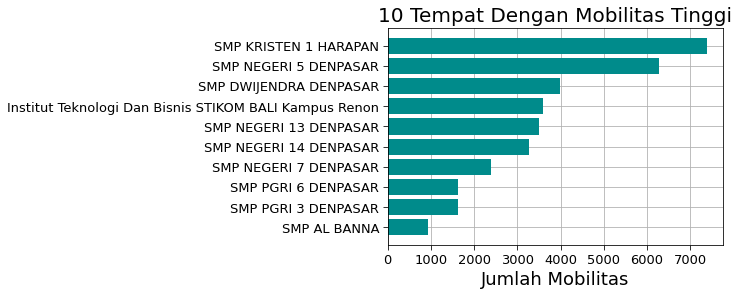

In [18]:
topcase('Jumlah','darkcyan')

In [19]:
df_final = df.groupby('Tanggal')['Jumlah'].sum()
df_final = df_final.to_frame().reset_index()
df_final.head()

,Tanggal,Jumlah
0,2021-09-01,0.0
1,2021-09-02,9.0
2,2021-09-03,9.0
3,2021-09-04,2.0
4,2021-09-05,17.0


In [20]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  61 non-null     datetime64[ns]
 1   Jumlah   61 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [21]:
df_final = df_final.set_index('Tanggal')
df_final['Jumlah'] = df_final['Jumlah'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2021-09-01 to 2021-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Jumlah  61 non-null     int64
dtypes: int64(1)
memory usage: 976.0 bytes


In [22]:
df_final

,Jumlah
Tanggal,
2021-09-01,0
2021-09-02,9
2021-09-03,9
2021-09-04,2
2021-09-05,17
...,...
2021-10-27,2841
2021-10-28,2842
2021-10-29,2113


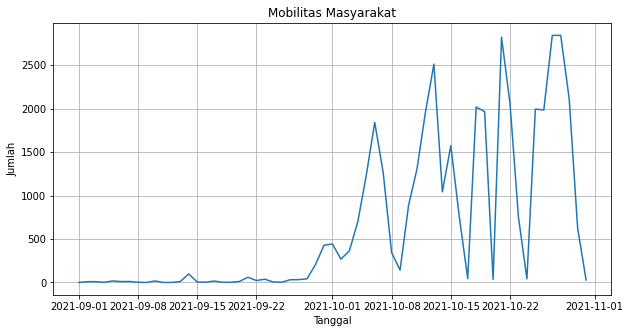

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Tanggal', y='Jumlah', data=df_final)
plt.title('Mobilitas Masyarakat')
plt.grid()
plt.show()

In [24]:
print("MAX : ", max(df_final['Jumlah']))
print("MIN : ", min(df_final['Jumlah']))

MAX :  2842
MIN :  0


In [25]:
df_final.describe()

,Jumlah
count,61.000000
mean,653.721311
std,895.169521
min,0.000000
25%,10.000000
50%,60.000000
75%,1231.000000
max,2842.000000


In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_final['scaled'] = scaler.fit_transform(df_final)

In [27]:
ratio = 0.9
n = int(ratio * len(df_final))
train = df_final[:n]
test = df_final[n:]

print(train.shape)
print(test.shape)

(54, 2)
(7, 2)


In [28]:
def sliding_window(data, time_steps):
    sub_seq, next_values = [], []
    for i in range(len(data)-time_steps):
        sub_seq.append(data[i:i+time_steps])
        next_values.append(data[i+time_steps])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

In [29]:
time_steps = 5
X_train, y_train = sliding_window(train[['scaled']].values, time_steps)
X_test, y_test = sliding_window(df_final[len(df_final)-len(test)-time_steps:][['scaled']].values, time_steps)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(49, 5, 1) (49, 1)
(7, 5, 1) (7, 1)


In [31]:
# define the grid search parameters
# LSTM_unit = [32,64,128,256,512]
# dropout = [0.1,0.2,0.3]
# optimizer= ['RMSProp', 'SGD', 'Adam']

In [32]:
# def create_model(LSTM_unit=0, dropout=0, optimizer=''):
#   # create model
#   model = Sequential()
#   model.add(LSTM(units=LSTM_unit, return_sequences = True, input_shape=(time_steps, 1)))
#   model.add(Dropout(dropout))
#   model.add(LSTM(units=LSTM_unit, return_sequences = True))
#   model.add(Dropout(dropout))
#   model.add(LSTM(units=LSTM_unit))
#   model.add(Dropout(dropout))
#   model.add(Dense(1))
#   # Compile model
#   model.compile(loss = 'mae', optimizer = optimizer, metrics=[RootMeanSquaredError()])
#   #model.summary()
#   return model

In [33]:
# Early Stopping
es = EarlyStopping(monitor = 'loss', mode = "min", patience = 20)

In [34]:
# # Hypertunning  
# model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=1, callbacks=[es])
# param = dict(LSTM_unit=LSTM_unit, dropout=dropout, optimizer=optimizer)
# grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1)

In [35]:
# # training
# grid_result = grid.fit(X_train, y_train)

In [36]:
# # results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
# # Mengambil model terbaik
# best_model_grid = grid_result.best_estimator_.model

In [37]:
model1 = Sequential()
model1.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model1.add(Dropout(0.1))
model1.add(LSTM(units=32, return_sequences = True))
model1.add(Dropout(0.1))
model1.add(LSTM(units=32))
model1.add(Dropout(0.1))
model1.add(Dense(1))
# Compile model
model1.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model1 = model1.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 5ms/step - loss: 0.0898 - root_mean_squared_error: 0.2997
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0802 - root_mean_squared_error: 0.2832
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805
Epoch 5/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0790 - root_mean_squared_error: 0.2811
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0778 - root_mean_squared_error: 0.2789
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0795 - root_mean_squared_error: 0.2820
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0772 - root_m

In [38]:
model2 = Sequential()
model2.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model2.add(Dropout(0.1))
model2.add(LSTM(units=32, return_sequences = True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=32))
model2.add(Dropout(0.1))
model2.add(Dense(1))
# Compile model
model2.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model2 = model2.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 6ms/step - loss: 0.0798 - root_mean_squared_error: 0.2824
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0607 - root_mean_squared_error: 0.2463
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0622 - root_mean_squared_error: 0.2493
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0667 - root_mean_squared_error: 0.2583
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0674 - root_mean_squared_error: 0.2597
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0615 - root_mean_squared_error: 0.2481
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0637 - root_m

In [39]:
model3 = Sequential()
model3.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model3.add(Dropout(0.1))
model3.add(LSTM(units=32, return_sequences = True))
model3.add(Dropout(0.1))
model3.add(LSTM(units=32))
model3.add(Dropout(0.1))
model3.add(Dense(1))
# Compile model
model3.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model3 = model3.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0834 - root_mean_squared_error: 0.2888
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0658 - root_mean_squared_error: 0.2565
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0625 - root_mean_squared_error: 0.2501
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0627 - root_mean_squared_error: 0.2503
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0648 - root_mean_squared_error: 0.2547
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0588 - root_mean_squared_error: 0.2426
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0621 - root_mean_squared_error: 0.2492
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0594 - root_mean_squared_error: 0.2437
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0573 - root_m

In [40]:
model4 = Sequential()
model4.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model4.add(Dropout(0.2))
model4.add(LSTM(units=32, return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(units=32))
model4.add(Dropout(0.2))
model4.add(Dense(1))
# Compile model
model4.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model4 = model4.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 5ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926
Epoch 2/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0785 - root_mean_squared_error: 0.2801
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764
Epoch 4/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0787 - root_mean_squared_error: 0.2806
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0802 - root_mean_squared_error: 0.2831
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0760 - root_mean_squared_error: 0.2756
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0778 - root_mean_squared_error: 0.2790
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0779 - root_m

In [41]:
model5 = Sequential()
model5.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model5.add(Dropout(0.2))
model5.add(LSTM(units=32, return_sequences = True))
model5.add(Dropout(0.2))
model5.add(LSTM(units=32))
model5.add(Dropout(0.2))
model5.add(Dense(1))
# Compile model
model5.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model5 = model5.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0777 - root_mean_squared_error: 0.2788
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0688 - root_mean_squared_error: 0.2624
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0617 - root_mean_squared_error: 0.2483
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0636 - root_mean_squared_error: 0.2522
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0615 - root_mean_squared_error: 0.2479
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0641 - root_m

In [42]:
model6 = Sequential()
model6.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model6.add(Dropout(0.2))
model6.add(LSTM(units=32, return_sequences = True))
model6.add(Dropout(0.2))
model6.add(LSTM(units=32))
model6.add(Dropout(0.2))
model6.add(Dense(1))
# Compile model
model6.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model6 = model6.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 7ms/step - loss: 0.0873 - root_mean_squared_error: 0.2955
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0654 - root_mean_squared_error: 0.2557
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0672 - root_mean_squared_error: 0.2593
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0619 - root_mean_squared_error: 0.2487
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0638 - root_mean_squared_error: 0.2526
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0618 - root_mean_squared_error: 0.2486
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0670 - root_mean_squared_error: 0.2588
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0581 - root_mean_squared_error: 0.2409
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0610 - root_m

In [43]:
model7 = Sequential()
model7.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model7.add(Dropout(0.3))
model7.add(LSTM(units=32, return_sequences = True))
model7.add(Dropout(0.3))
model7.add(LSTM(units=32))
model7.add(Dropout(0.3))
model7.add(Dense(1))
# Compile model
model7.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model7 = model7.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0876 - root_mean_squared_error: 0.2960
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0754 - root_mean_squared_error: 0.2746
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0762 - root_mean_squared_error: 0.2761
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0806 - root_mean_squared_error: 0.2839
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0761 - root_mean_squared_error: 0.2759
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0778 - root_mean_squared_error: 0.2789
Epoch 9/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0783 - root_m

In [44]:
model8 = Sequential()
model8.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model8.add(Dropout(0.3))
model8.add(LSTM(units=32, return_sequences = True))
model8.add(Dropout(0.3))
model8.add(LSTM(units=32))
model8.add(Dropout(0.3))
model8.add(Dense(1))
# Compile model
model8.compile(loss = 'mse', optimizer = 'RMSprop', metrics=[RootMeanSquaredError()])
history_model8 = model8.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0639 - root_mean_squared_error: 0.2528
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0659 - root_mean_squared_error: 0.2566
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0602 - root_mean_squared_error: 0.2453
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0671 - root_mean_squared_error: 0.2590
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0687 - root_mean_squared_error: 0.2622
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0649 - root_m

In [45]:
model9 = Sequential()
model9.add(LSTM(units=32, return_sequences = True, input_shape=(time_steps, 1)))
model9.add(Dropout(0.3))
model9.add(LSTM(units=32, return_sequences = True))
model9.add(Dropout(0.3))
model9.add(LSTM(units=32))
model9.add(Dropout(0.3))
model9.add(Dense(1))
# Compile model
model9.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model9 = model9.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 6ms/step - loss: 0.0782 - root_mean_squared_error: 0.2796
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0586 - root_mean_squared_error: 0.2421
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0684 - root_mean_squared_error: 0.2616
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0557 - root_mean_squared_error: 0.2361
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0609 - root_mean_squared_error: 0.2468
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0621 - root_mean_squared_error: 0.2493
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0611 - root_m

In [46]:
model10 = Sequential()
model10.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model10.add(Dropout(0.1))
model10.add(LSTM(units=64, return_sequences = True))
model10.add(Dropout(0.1))
model10.add(LSTM(units=64))
model10.add(Dropout(0.1))
model10.add(Dense(1))
# Compile model
model10.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model10 = model10.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 5ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0766 - root_mean_squared_error: 0.2768
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0777 - root_mean_squared_error: 0.2787
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0768 - root_mean_squared_error: 0.2771
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0769 - root_mean_squared_error: 0.2773
Epoch 8/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0759 - root_mean_squared_error: 0.2754
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0762 - root_m

In [47]:
model11 = Sequential()
model11.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model11.add(Dropout(0.1))
model11.add(LSTM(units=64, return_sequences = True))
model11.add(Dropout(0.1))
model11.add(LSTM(units=64))
model11.add(Dropout(0.1))
model11.add(Dense(1))
# Compile model
model11.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model11 = model11.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 7ms/step - loss: 0.0730 - root_mean_squared_error: 0.2701
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0692 - root_mean_squared_error: 0.2630
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0623 - root_mean_squared_error: 0.2495
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0724 - root_mean_squared_error: 0.2691
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0622 - root_mean_squared_error: 0.2494
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0633 - root_mean_squared_error: 0.2517
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0464 - root_m

In [48]:
model12 = Sequential()
model12.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model12.add(Dropout(0.1))
model12.add(LSTM(units=64, return_sequences = True))
model12.add(Dropout(0.1))
model12.add(LSTM(units=64))
model12.add(Dropout(0.1))
model12.add(Dense(1))
 # Compile model
model12.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model12 = model12.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 6ms/step - loss: 0.0707 - root_mean_squared_error: 0.2659
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0619 - root_mean_squared_error: 0.2489
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0709 - root_mean_squared_error: 0.2664
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0617 - root_mean_squared_error: 0.2484
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0606 - root_m

In [49]:
model13 = Sequential()
model13.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model13.add(Dropout(0.2))
model13.add(LSTM(units=64, return_sequences = True))
model13.add(Dropout(0.2))
model13.add(LSTM(units=64))
model13.add(Dropout(0.2))
model13.add(Dense(1))
# Compile model
model13.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model13 = model13.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0889 - root_mean_squared_error: 0.2981
Epoch 2/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0802 - root_mean_squared_error: 0.2831
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0790 - root_mean_squared_error: 0.2810
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0808 - root_mean_squared_error: 0.2842
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0792 - root_mean_squared_error: 0.2814
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0771 - root_mean_squared_error: 0.2778
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0778 - root_m

In [50]:
model14 = Sequential()
model14.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model14.add(Dropout(0.2))
model14.add(LSTM(units=64, return_sequences = True))
model14.add(Dropout(0.2))
model14.add(LSTM(units=64))
model14.add(Dropout(0.2))
model14.add(Dense(1))
# Compile model
model14.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model14 = model14.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0611 - root_mean_squared_error: 0.2471
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0648 - root_mean_squared_error: 0.2546
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0642 - root_mean_squared_error: 0.2533
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0802 - root_mean_squared_error: 0.2832
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0702 - root_mean_squared_error: 0.2649
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0704 - root_mean_squared_error: 0.2654
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0613 - root_m

In [51]:
model15 = Sequential()
model15.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model15.add(Dropout(0.2))
model15.add(LSTM(units=64, return_sequences = True))
model15.add(Dropout(0.2))
model15.add(LSTM(units=64))
model15.add(Dropout(0.2))
model15.add(Dense(1))
# Compile model
model15.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model15 = model15.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 9ms/step - loss: 0.0789 - root_mean_squared_error: 0.2809
Epoch 2/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0697 - root_mean_squared_error: 0.2639
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0626 - root_mean_squared_error: 0.2502
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0628 - root_mean_squared_error: 0.2505
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0633 - root_m

In [52]:
model16 = Sequential()
model16.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model16.add(Dropout(0.3))
model16.add(LSTM(units=64, return_sequences = True))
model16.add(Dropout(0.3))
model16.add(LSTM(units=64))
model16.add(Dropout(0.3))
model16.add(Dense(1))
# Compile model
model16.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model16 = model16.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 6ms/step - loss: 0.0882 - root_mean_squared_error: 0.2970
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0788 - root_mean_squared_error: 0.2808
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0787 - root_mean_squared_error: 0.2806
Epoch 4/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0798 - root_mean_squared_error: 0.2824
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0772 - root_mean_squared_error: 0.2778
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0781 - root_mean_squared_error: 0.2794
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0752 - root_mean_squared_error: 0.2743
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0766 - root_mean_squared_error: 0.2767
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0794 - root_m

In [53]:
model17 = Sequential()
model17.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model17.add(Dropout(0.3))
model17.add(LSTM(units=64, return_sequences = True))
model17.add(Dropout(0.3))
model17.add(LSTM(units=64))
model17.add(Dropout(0.3))
model17.add(Dense(1))
# Compile model
model17.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model17 = model17.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 6ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0633 - root_mean_squared_error: 0.2516
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0677 - root_mean_squared_error: 0.2602
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0629 - root_mean_squared_error: 0.2508
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0644 - root_mean_squared_error: 0.2538
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0577 - root_mean_squared_error: 0.2401
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0727 - root_m

In [54]:
model18 = Sequential()
model18.add(LSTM(units=64, return_sequences = True, input_shape=(time_steps, 1)))
model18.add(Dropout(0.3))
model18.add(LSTM(units=64, return_sequences = True))
model18.add(Dropout(0.3))
model18.add(LSTM(units=64))
model18.add(Dropout(0.3))
model18.add(Dense(1))
# Compile model
model18.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model18 = model18.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 6ms/step - loss: 0.0766 - root_mean_squared_error: 0.2768
Epoch 2/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0644 - root_mean_squared_error: 0.2537
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534
Epoch 5/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0789 - root_mean_squared_error: 0.2808
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0664 - root_mean_squared_error: 0.2578
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0625 - root_mean_squared_error: 0.2499
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380
Epoch 9/500
49/49 [==============================] - 0s 6ms/step - loss: 0.0570 - root_m

In [55]:
model19 = Sequential()
model19.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model19.add(Dropout(0.1))
model19.add(LSTM(units=128, return_sequences = True))
model19.add(Dropout(0.1))
model19.add(LSTM(units=128))
model19.add(Dropout(0.1))
model19.add(Dense(1))
# Compile model
model19.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model19 = model19.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 8ms/step - loss: 0.0855 - root_mean_squared_error: 0.2925
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0768 - root_mean_squared_error: 0.2771
Epoch 3/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0780 - root_mean_squared_error: 0.2792
Epoch 5/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0788 - root_mean_squared_error: 0.2806
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0787 - root_mean_squared_error: 0.2806
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0779 - root_mean_squared_error: 0.2792
Epoch 8/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0764 - root_mean_squared_error: 0.2765
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0775 - root_m

In [56]:
model20 = Sequential()
model20.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model20.add(Dropout(0.1))
model20.add(LSTM(units=128, return_sequences = True))
model20.add(Dropout(0.1))
model20.add(LSTM(units=128))
model20.add(Dropout(0.1))
model20.add(Dense(1))
# Compile model
model20.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model20 = model20.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 11ms/step - loss: 0.0778 - root_mean_squared_error: 0.2790
Epoch 2/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0619 - root_mean_squared_error: 0.2488
Epoch 3/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692
Epoch 4/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0730 - root_mean_squared_error: 0.2702
Epoch 5/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535
Epoch 6/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0672 - root_mean_squared_error: 0.2592
Epoch 7/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0624 - root_mean_squared_error: 0.2497
Epoch 8/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0641 - root_mean_squared_error: 0.2531
Epoch 9/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0601 - roo

In [57]:
model21 = Sequential()
model21.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model21.add(Dropout(0.1))
model21.add(LSTM(units=128, return_sequences = True))
model21.add(Dropout(0.1))
model21.add(LSTM(units=128))
model21.add(Dropout(0.1))
model21.add(Dense(1))
# Compile model
model21.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model21 = model21.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 9ms/step - loss: 0.0783 - root_mean_squared_error: 0.2797
Epoch 2/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0662 - root_mean_squared_error: 0.2573
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554
Epoch 4/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559
Epoch 5/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0616 - root_mean_squared_error: 0.2483
Epoch 6/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0549 - root_mean_squared_error: 0.2343
Epoch 7/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448
Epoch 8/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0597 - root_m

In [58]:
model22 = Sequential()
model22.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model22.add(Dropout(0.2))
model22.add(LSTM(units=128, return_sequences = True))
model22.add(Dropout(0.2))
model22.add(LSTM(units=128))
model22.add(Dropout(0.2))
model22.add(Dense(1))
# Compile model
model22.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model22 = model22.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 7ms/step - loss: 0.0888 - root_mean_squared_error: 0.2980
Epoch 2/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0792 - root_mean_squared_error: 0.2814
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0773 - root_mean_squared_error: 0.2779
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758
Epoch 5/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0773 - root_mean_squared_error: 0.2781
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0751 - root_mean_squared_error: 0.2740
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0764 - root_mean_squared_error: 0.2763
Epoch 8/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763
Epoch 9/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0746 - root_m

In [59]:
model23 = Sequential()
model23.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model23.add(Dropout(0.2))
model23.add(LSTM(units=128, return_sequences = True))
model23.add(Dropout(0.2))
model23.add(LSTM(units=128))
model23.add(Dropout(0.2))
model23.add(Dense(1))
# Compile model
model23.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model23 = model23.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 9ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793
Epoch 2/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0685 - root_mean_squared_error: 0.2618
Epoch 3/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0686 - root_mean_squared_error: 0.2618
Epoch 4/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0676 - root_mean_squared_error: 0.2599
Epoch 5/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271
Epoch 6/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0846 - root_mean_squared_error: 0.2908
Epoch 7/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0562 - root_mean_squared_error: 0.2370
Epoch 8/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0777 - root_mean_squared_error: 0.2787
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0588 - root

In [60]:
model24 = Sequential()
model24.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model24.add(Dropout(0.2))
model24.add(LSTM(units=128, return_sequences = True))
model24.add(Dropout(0.2))
model24.add(LSTM(units=128))
model24.add(Dropout(0.2))
model24.add(Dense(1))
# Compile model
model24.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model24 = model24.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 4s 7ms/step - loss: 0.0794 - root_mean_squared_error: 0.2818
Epoch 2/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0665 - root_mean_squared_error: 0.2580
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0613 - root_mean_squared_error: 0.2475
Epoch 4/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0691 - root_mean_squared_error: 0.2628
Epoch 5/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451
Epoch 6/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480
Epoch 7/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595
Epoch 8/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0547 - root_m

In [61]:
 model25 = Sequential()
 model25.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
 model25.add(Dropout(0.3))
 model25.add(LSTM(units=128, return_sequences = True))
 model25.add(Dropout(0.3))
 model25.add(LSTM(units=128))
 model25.add(Dropout(0.3))
 model25.add(Dense(1))
 # Compile model
 model25.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
 history_model25 = model25.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 12ms/step - loss: 0.0911 - root_mean_squared_error: 0.3018
Epoch 2/500
49/49 [==============================] - 1s 13ms/step - loss: 0.0798 - root_mean_squared_error: 0.2825
Epoch 3/500
49/49 [==============================] - 1s 11ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807
Epoch 5/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0786 - root_mean_squared_error: 0.2804
Epoch 6/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.0789 - root_mean_squared_error: 0.2808
Epoch 8/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0788 - roo

In [62]:
model26 = Sequential()
model26.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model26.add(Dropout(0.3))
model26.add(LSTM(units=128, return_sequences = True))
model26.add(Dropout(0.3))
model26.add(LSTM(units=128))
model26.add(Dropout(0.3))
model26.add(Dense(1))
# Compile model
model26.compile(loss = 'mse', optimizer = 'RMSprop', metrics=[RootMeanSquaredError()])
history_model26 = model26.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 9ms/step - loss: 0.0741 - root_mean_squared_error: 0.2723
Epoch 2/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0656 - root_mean_squared_error: 0.2562
Epoch 3/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0738 - root_mean_squared_error: 0.2718
Epoch 4/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563
Epoch 5/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0722 - root_mean_squared_error: 0.2686
Epoch 6/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627
Epoch 7/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0681 - root_mean_squared_error: 0.2610
Epoch 8/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0595 - root_mean_squared_error: 0.2440
Epoch 9/500
49/49 [==============================] - 0s 10ms/step - loss: 0.0514 - ro

In [63]:
model27 = Sequential()
model27.add(LSTM(units=128, return_sequences = True, input_shape=(time_steps, 1)))
model27.add(Dropout(0.3))
model27.add(LSTM(units=128, return_sequences = True))
model27.add(Dropout(0.3))
model27.add(LSTM(units=128))
model27.add(Dropout(0.3))
model27.add(Dense(1))
# Compile model
model27.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model27 = model27.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 9ms/step - loss: 0.0731 - root_mean_squared_error: 0.2705
Epoch 2/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0744 - root_mean_squared_error: 0.2728
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585
Epoch 4/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0625 - root_mean_squared_error: 0.2501
Epoch 5/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0615 - root_mean_squared_error: 0.2481
Epoch 6/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0808 - root_mean_squared_error: 0.2843
Epoch 7/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0703 - root_mean_squared_error: 0.2652
Epoch 8/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0616 - root_mean_squared_error: 0.2482
Epoch 9/500
49/49 [==============================] - 0s 9ms/step - loss: 0.0590 - root_m

In [64]:
model28 = Sequential()
model28.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model28.add(Dropout(0.1))
model28.add(LSTM(units=256, return_sequences = True))
model28.add(Dropout(0.1))
model28.add(LSTM(units=256))
model28.add(Dropout(0.1))
model28.add(Dense(1))
# Compile model
model28.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model28 = model28.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 20ms/step - loss: 0.0857 - root_mean_squared_error: 0.2927
Epoch 2/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797
Epoch 3/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798
Epoch 4/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0773 - root_mean_squared_error: 0.2780
Epoch 5/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0779 - root_mean_squared_error: 0.2792
Epoch 6/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 7/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776
Epoch 8/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750
Epoch 9/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0750

In [65]:
model29 = Sequential()
model29.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model29.add(Dropout(0.1))
model29.add(LSTM(units=256, return_sequences = True))
model29.add(Dropout(0.1))
model29.add(LSTM(units=256))
model29.add(Dropout(0.1))
model29.add(Dense(1))
# Compile model
model29.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model29 = model29.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 28ms/step - loss: 0.0799 - root_mean_squared_error: 0.2827
Epoch 2/500
49/49 [==============================] - 1s 27ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305
Epoch 3/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0820 - root_mean_squared_error: 0.2863
Epoch 4/500
49/49 [==============================] - 1s 29ms/step - loss: 0.0695 - root_mean_squared_error: 0.2637
Epoch 5/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0608 - root_mean_squared_error: 0.2466
Epoch 6/500
49/49 [==============================] - 1s 29ms/step - loss: 0.0675 - root_mean_squared_error: 0.2599
Epoch 7/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0729 - root_mean_squared_error: 0.2701
Epoch 8/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0650 - root_mean_squared_error: 0.2549
Epoch 9/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0590

In [66]:
model30 = Sequential()
model30.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model30.add(Dropout(0.1))
model30.add(LSTM(units=256, return_sequences = True))
model30.add(Dropout(0.1))
model30.add(LSTM(units=256))
model30.add(Dropout(0.1))
model30.add(Dense(1))
# Compile model
model30.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model30 = model30.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 21ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715
Epoch 2/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0657 - root_mean_squared_error: 0.2562
Epoch 3/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585
Epoch 4/500
49/49 [==============================] - 1s 23ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520
Epoch 5/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0536 - root_mean_squared_error: 0.2315
Epoch 6/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0807 - root_mean_squared_error: 0.2840
Epoch 7/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273
Epoch 8/500
49/49 [==============================] - 1s 23ms/step - loss: 0.0637 - root_mean_squared_error: 0.2523
Epoch 9/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0539

In [67]:
model31 = Sequential()
model31.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model31.add(Dropout(0.2))
model31.add(LSTM(units=256, return_sequences = True))
model31.add(Dropout(0.2))
model31.add(LSTM(units=256))
model31.add(Dropout(0.2))
model31.add(Dense(1))
# Compile model
model31.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model31 = model31.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 19ms/step - loss: 0.0863 - root_mean_squared_error: 0.2938
Epoch 2/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0789 - root_mean_squared_error: 0.2808
Epoch 3/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0781 - root_mean_squared_error: 0.2795
Epoch 4/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0789 - root_mean_squared_error: 0.2810
Epoch 5/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0776 - root_mean_squared_error: 0.2786
Epoch 6/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0784 - root_mean_squared_error: 0.2800
Epoch 7/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0766 - root_mean_squared_error: 0.2768
Epoch 8/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793
Epoch 9/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0780

In [68]:
model32 = Sequential()
model32.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model32.add(Dropout(0.2))
model32.add(LSTM(units=256, return_sequences = True))
model32.add(Dropout(0.2))
model32.add(LSTM(units=256))
model32.add(Dropout(0.2))
model32.add(Dense(1))
# Compile model
model32.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model32 = model32.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 28ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750
Epoch 2/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0775 - root_mean_squared_error: 0.2784
Epoch 3/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0754 - root_mean_squared_error: 0.2747
Epoch 4/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0710 - root_mean_squared_error: 0.2664
Epoch 5/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0708 - root_mean_squared_error: 0.2662
Epoch 6/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0662 - root_mean_squared_error: 0.2573
Epoch 7/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0702 - root_mean_squared_error: 0.2649
Epoch 8/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0596 - root_mean_squared_error: 0.2440
Epoch 9/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0641

In [69]:
model33 = Sequential()
model33.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model33.add(Dropout(0.2))
model33.add(LSTM(units=256, return_sequences = True))
model33.add(Dropout(0.2))
model33.add(LSTM(units=256))
model33.add(Dropout(0.2))
model33.add(Dense(1))
# Compile model
model33.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model33 = model33.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 21ms/step - loss: 0.0793 - root_mean_squared_error: 0.2817
Epoch 2/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0699 - root_mean_squared_error: 0.2644
Epoch 3/500
49/49 [==============================] - 1s 23ms/step - loss: 0.0671 - root_mean_squared_error: 0.2591
Epoch 4/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0696 - root_mean_squared_error: 0.2638
Epoch 5/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0702 - root_mean_squared_error: 0.2649
Epoch 6/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0596 - root_mean_squared_error: 0.2441
Epoch 7/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0626 - root_mean_squared_error: 0.2503
Epoch 8/500
49/49 [==============================] - 1s 22ms/step - loss: 0.0590 - root_mean_squared_error: 0.2428
Epoch 9/500
49/49 [==============================] - 1s 23ms/step - loss: 0.0558

In [70]:
model34 = Sequential()
model34.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model34.add(Dropout(0.3))
model34.add(LSTM(units=256, return_sequences = True))
model34.add(Dropout(0.3))
model34.add(LSTM(units=256))
model34.add(Dropout(0.3))
model34.add(Dense(1))
# Compile model
model34.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model34 = model34.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 19ms/step - loss: 0.0848 - root_mean_squared_error: 0.2911
Epoch 2/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0783 - root_mean_squared_error: 0.2797
Epoch 3/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774
Epoch 4/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0754 - root_mean_squared_error: 0.2746
Epoch 5/500
49/49 [==============================] - 1s 20ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776
Epoch 6/500
49/49 [==============================] - 1s 21ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760
Epoch 7/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0746 - root_mean_squared_error: 0.2732
Epoch 8/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0776 - root_mean_squared_error: 0.2786
Epoch 9/500
49/49 [==============================] - 1s 19ms/step - loss: 0.0766

In [71]:
model35 = Sequential()
model35.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model35.add(Dropout(0.3))
model35.add(LSTM(units=256, return_sequences = True))
model35.add(Dropout(0.3))
model35.add(LSTM(units=256))
model35.add(Dropout(0.3))
model35.add(Dense(1))
# Compile model
model35.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model35 = model35.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 6s 27ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926
Epoch 2/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0718 - root_mean_squared_error: 0.2679
Epoch 3/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692
Epoch 4/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0675 - root_mean_squared_error: 0.2599
Epoch 5/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0775 - root_mean_squared_error: 0.2784
Epoch 6/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585
Epoch 7/500
49/49 [==============================] - 1s 26ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667
Epoch 8/500
49/49 [==============================] - 1s 27ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510
Epoch 9/500
49/49 [==============================] - 1s 28ms/step - loss: 0.0607

In [72]:
model36 = Sequential()
model36.add(LSTM(units=256, return_sequences = True, input_shape=(time_steps, 1)))
model36.add(Dropout(0.3))
model36.add(LSTM(units=256, return_sequences = True))
model36.add(Dropout(0.3))
model36.add(LSTM(units=256))
model36.add(Dropout(0.3))
model36.add(Dense(1))
# Compile model
model36.compile(loss = 'mae', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model36 = model36.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 5s 21ms/step - loss: 0.1730 - root_mean_squared_error: 0.3057
Epoch 2/500
49/49 [==============================] - 1s 21ms/step - loss: 0.1871 - root_mean_squared_error: 0.2947
Epoch 3/500
49/49 [==============================] - 1s 22ms/step - loss: 0.1592 - root_mean_squared_error: 0.2577
Epoch 4/500
49/49 [==============================] - 1s 22ms/step - loss: 0.1747 - root_mean_squared_error: 0.2807
Epoch 5/500
49/49 [==============================] - 1s 22ms/step - loss: 0.1512 - root_mean_squared_error: 0.2552
Epoch 6/500
49/49 [==============================] - 1s 22ms/step - loss: 0.1725 - root_mean_squared_error: 0.2760
Epoch 7/500
49/49 [==============================] - 1s 24ms/step - loss: 0.1594 - root_mean_squared_error: 0.2487
Epoch 8/500
49/49 [==============================] - 1s 21ms/step - loss: 0.1625 - root_mean_squared_error: 0.2618
Epoch 9/500
49/49 [==============================] - 1s 21ms/step - loss: 0.1510

In [73]:
model37 = Sequential()
model37.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model37.add(Dropout(0.1))
model37.add(LSTM(units=512, return_sequences = True))
model37.add(Dropout(0.1))
model37.add(LSTM(units=512))
model37.add(Dropout(0.1))
model37.add(Dense(1))
# Compile model
model37.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model37 = model37.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 7s 61ms/step - loss: 0.0905 - root_mean_squared_error: 0.3009
Epoch 2/500
49/49 [==============================] - 3s 60ms/step - loss: 0.0793 - root_mean_squared_error: 0.2817
Epoch 3/500
49/49 [==============================] - 3s 58ms/step - loss: 0.0789 - root_mean_squared_error: 0.2808
Epoch 4/500
49/49 [==============================] - 3s 59ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798
Epoch 5/500
49/49 [==============================] - 3s 59ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776
Epoch 6/500
49/49 [==============================] - 3s 61ms/step - loss: 0.0788 - root_mean_squared_error: 0.2808
Epoch 7/500
49/49 [==============================] - 3s 60ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760
Epoch 8/500
49/49 [==============================] - 3s 60ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802
Epoch 9/500
49/49 [==============================] - 3s 59ms/step - loss: 0.0784

In [74]:
model38 = Sequential()
model38.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model38.add(Dropout(0.1))
model38.add(LSTM(units=512, return_sequences = True))
model38.add(Dropout(0.1))
model38.add(LSTM(units=512))
model38.add(Dropout(0.1))
model38.add(Dense(1))
# Compile model
model38.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model38 = model38.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 8s 83ms/step - loss: 0.0790 - root_mean_squared_error: 0.2810
Epoch 2/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0793 - root_mean_squared_error: 0.2816
Epoch 3/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0779 - root_mean_squared_error: 0.2792
Epoch 4/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0748 - root_mean_squared_error: 0.2735
Epoch 5/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695
Epoch 6/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0712 - root_mean_squared_error: 0.2668
Epoch 7/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0585 - root_mean_squared_error: 0.2419
Epoch 8/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559
Epoch 9/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0529

In [75]:
model39 = Sequential()
model39.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model39.add(Dropout(0.1))
model39.add(LSTM(units=512, return_sequences = True))
model39.add(Dropout(0.1))
model39.add(LSTM(units=512))
model39.add(Dropout(0.1))
model39.add(Dense(1))
# Compile model
model39.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model39 = model39.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 7s 70ms/step - loss: 0.0957 - root_mean_squared_error: 0.3093
Epoch 2/500
49/49 [==============================] - 3s 67ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617
Epoch 3/500
49/49 [==============================] - 3s 68ms/step - loss: 0.0699 - root_mean_squared_error: 0.2644
Epoch 4/500
49/49 [==============================] - 3s 68ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 5/500
49/49 [==============================] - 3s 68ms/step - loss: 0.0716 - root_mean_squared_error: 0.2675
Epoch 6/500
49/49 [==============================] - 3s 70ms/step - loss: 0.0873 - root_mean_squared_error: 0.2955
Epoch 7/500
49/49 [==============================] - 3s 70ms/step - loss: 0.0552 - root_mean_squared_error: 0.2349
Epoch 8/500
49/49 [==============================] - 3s 70ms/step - loss: 0.0729 - root_mean_squared_error: 0.2700
Epoch 9/500
49/49 [==============================] - 3s 69ms/step - loss: 0.0560

In [76]:
model40 = Sequential()
model40.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model40.add(Dropout(0.2))
model40.add(LSTM(units=512, return_sequences = True))
model40.add(Dropout(0.2))
model40.add(LSTM(units=512))
model40.add(Dropout(0.2))
model40.add(Dense(1))
# Compile model
model40.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model40 = model40.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 7s 60ms/step - loss: 0.0850 - root_mean_squared_error: 0.2915
Epoch 2/500
49/49 [==============================] - 3s 60ms/step - loss: 0.0772 - root_mean_squared_error: 0.2779
Epoch 3/500
49/49 [==============================] - 3s 59ms/step - loss: 0.0775 - root_mean_squared_error: 0.2783
Epoch 4/500
49/49 [==============================] - 3s 61ms/step - loss: 0.0788 - root_mean_squared_error: 0.2806
Epoch 5/500
49/49 [==============================] - 3s 60ms/step - loss: 0.0767 - root_mean_squared_error: 0.2770
Epoch 6/500
49/49 [==============================] - 3s 58ms/step - loss: 0.0754 - root_mean_squared_error: 0.2747
Epoch 7/500
49/49 [==============================] - 3s 58ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802
Epoch 8/500
49/49 [==============================] - 3s 58ms/step - loss: 0.0764 - root_mean_squared_error: 0.2763
Epoch 9/500
49/49 [==============================] - 3s 57ms/step - loss: 0.0778

In [77]:
model41 = Sequential()
model41.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model41.add(Dropout(0.2))
model41.add(LSTM(units=512, return_sequences = True))
model41.add(Dropout(0.2))
model41.add(LSTM(units=512))
model41.add(Dropout(0.2))
model41.add(Dense(1))
# Compile model
model41.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model41 = model41.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 8s 83ms/step - loss: 0.0855 - root_mean_squared_error: 0.2924
Epoch 2/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0770 - root_mean_squared_error: 0.2775
Epoch 3/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939
Epoch 4/500
49/49 [==============================] - 4s 83ms/step - loss: 0.0983 - root_mean_squared_error: 0.3136
Epoch 5/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0750 - root_mean_squared_error: 0.2738
Epoch 6/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0780 - root_mean_squared_error: 0.2792
Epoch 7/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0665 - root_mean_squared_error: 0.2579
Epoch 8/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0681 - root_mean_squared_error: 0.2610
Epoch 9/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0595

In [78]:
model42 = Sequential()
model42.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model42.add(Dropout(0.2))
model42.add(LSTM(units=512, return_sequences = True))
model42.add(Dropout(0.2))
model42.add(LSTM(units=512))
model42.add(Dropout(0.2))
model42.add(Dense(1))
# Compile model
model42.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model42 = model42.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 7s 70ms/step - loss: 0.0888 - root_mean_squared_error: 0.2980
Epoch 2/500
49/49 [==============================] - 3s 68ms/step - loss: 0.0754 - root_mean_squared_error: 0.2745
Epoch 3/500
49/49 [==============================] - 3s 70ms/step - loss: 0.0649 - root_mean_squared_error: 0.2548
Epoch 4/500
49/49 [==============================] - 4s 72ms/step - loss: 0.0626 - root_mean_squared_error: 0.2502
Epoch 5/500
49/49 [==============================] - 3s 69ms/step - loss: 0.0834 - root_mean_squared_error: 0.2887
Epoch 6/500
49/49 [==============================] - 3s 68ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555
Epoch 7/500
49/49 [==============================] - 3s 69ms/step - loss: 0.0654 - root_mean_squared_error: 0.2557
Epoch 8/500
49/49 [==============================] - 3s 69ms/step - loss: 0.0635 - root_mean_squared_error: 0.2519
Epoch 9/500
49/49 [==============================] - 3s 69ms/step - loss: 0.0606

In [79]:
model43 = Sequential()
model43.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model43.add(Dropout(0.3))
model43.add(LSTM(units=512, return_sequences = True))
model43.add(Dropout(0.3))
model43.add(LSTM(units=512))
model43.add(Dropout(0.3))
model43.add(Dense(1))
# Compile model
model43.compile(loss = 'mse', optimizer = 'SGD', metrics=[RootMeanSquaredError()])
history_model43 = model43.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 8s 78ms/step - loss: 0.0854 - root_mean_squared_error: 0.2923
Epoch 2/500
49/49 [==============================] - 4s 78ms/step - loss: 0.0781 - root_mean_squared_error: 0.2795
Epoch 3/500
49/49 [==============================] - 4s 80ms/step - loss: 0.0778 - root_mean_squared_error: 0.2790
Epoch 4/500
49/49 [==============================] - 4s 80ms/step - loss: 0.0784 - root_mean_squared_error: 0.2801
Epoch 5/500
49/49 [==============================] - 4s 78ms/step - loss: 0.0790 - root_mean_squared_error: 0.2811
Epoch 6/500
49/49 [==============================] - 4s 79ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776
Epoch 7/500
49/49 [==============================] - 4s 75ms/step - loss: 0.0767 - root_mean_squared_error: 0.2769
Epoch 8/500
49/49 [==============================] - 4s 78ms/step - loss: 0.0785 - root_mean_squared_error: 0.2801
Epoch 9/500
49/49 [==============================] - 4s 78ms/step - loss: 0.0765

In [80]:
model44 = Sequential()
model44.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model44.add(Dropout(0.3))
model44.add(LSTM(units=512, return_sequences = True))
model44.add(Dropout(0.3))
model44.add(LSTM(units=512))
model44.add(Dropout(0.3))
model44.add(Dense(1))
# Compile model
model44.compile(loss = 'mse', optimizer = 'RMSProp', metrics=[RootMeanSquaredError()])
history_model44 = model44.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 10s 106ms/step - loss: 0.0815 - root_mean_squared_error: 0.2854
Epoch 2/500
49/49 [==============================] - 5s 108ms/step - loss: 0.0694 - root_mean_squared_error: 0.2634
Epoch 3/500
49/49 [==============================] - 5s 106ms/step - loss: 0.0740 - root_mean_squared_error: 0.2721
Epoch 4/500
49/49 [==============================] - 5s 107ms/step - loss: 0.0865 - root_mean_squared_error: 0.2941
Epoch 5/500
49/49 [==============================] - 5s 107ms/step - loss: 0.0891 - root_mean_squared_error: 0.2986
Epoch 6/500
49/49 [==============================] - 5s 107ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807
Epoch 7/500
49/49 [==============================] - 5s 105ms/step - loss: 0.0662 - root_mean_squared_error: 0.2574
Epoch 8/500
49/49 [==============================] - 5s 106ms/step - loss: 0.0814 - root_mean_squared_error: 0.2854
Epoch 9/500
49/49 [==============================] - 5s 107ms/step - lo

In [81]:
model45 = Sequential()
model45.add(LSTM(units=512, return_sequences = True, input_shape=(time_steps, 1)))
model45.add(Dropout(0.3))
model45.add(LSTM(units=512, return_sequences = True))
model45.add(Dropout(0.3))
model45.add(LSTM(units=512))
model45.add(Dropout(0.3))
model45.add(Dense(1))
# Compile model
model45.compile(loss = 'mse', optimizer = 'Adam', metrics=[RootMeanSquaredError()])
history_model45 = model45.fit(X_train, y_train, epochs=500, batch_size=1, callbacks=[es])

Epoch 1/500
49/49 [==============================] - 9s 86ms/step - loss: 0.0755 - root_mean_squared_error: 0.2748
Epoch 2/500
49/49 [==============================] - 4s 89ms/step - loss: 0.0672 - root_mean_squared_error: 0.2593
Epoch 3/500
49/49 [==============================] - 4s 90ms/step - loss: 0.0751 - root_mean_squared_error: 0.2741
Epoch 4/500
49/49 [==============================] - 4s 88ms/step - loss: 0.0682 - root_mean_squared_error: 0.2612
Epoch 5/500
49/49 [==============================] - 4s 85ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716
Epoch 6/500
49/49 [==============================] - 4s 88ms/step - loss: 0.0690 - root_mean_squared_error: 0.2626
Epoch 7/500
49/49 [==============================] - 4s 90ms/step - loss: 0.0703 - root_mean_squared_error: 0.2651
Epoch 8/500
49/49 [==============================] - 4s 87ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692
Epoch 9/500
49/49 [==============================] - 4s 84ms/step - loss: 0.0670

In [83]:
for i in range(45):
  test['model%s' %(i+1)] = scaler.inverse_transform(globals()["model%s"%(i+1)].predict(X_test))

In [84]:
test

,Jumlah,scaled,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-25,1993,0.701267,653.176453,874.821777,1006.627014,965.418091,1185.037231,1139.001709,1094.339233,1311.284790,1079.343018,962.690979,924.115906,1170.573486,918.545776,994.659058,1148.274170,670.576233,1324.955444,1032.350586,1124.987549,1259.558472,1653.488770,921.494568,1017.478821,1009.246826,973.430847,1354.891479,943.933899,969.346680,1118.465454,1021.933655,1122.767334,1568.373047,1388.739014,571.479004,1050.826538,939.383179,1123.022095,629.474792,602.801819,770.340820,626.952515,1372.353760,546.579163,397.026154,1598.697876
2021-10-26,1984,0.698100,741.998352,374.175293,686.423767,1226.199951,808.370361,761.731995,1341.379761,998.456116,749.219421,1253.328857,377.478119,865.240051,1186.130371,666.093872,817.671082,686.892395,962.047913,829.133057,1336.185059,1083.940063,1408.741943,1180.902588,1077.373169,1377.627075,1248.908447,1074.472778,797.577881,1210.109253,1091.351196,1260.997925,1391.292236,1459.295166,1223.417114,595.439941,1277.650146,957.274292,1384.840576,2237.771973,1994.281250,858.202637,932.149353,1696.059937,575.141357,1942.783081,1877.469727
2021-10-27,2841,0.999648,641.360107,724.725769,939.013794,941.070374,1082.668823,1069.311401,1073.006592,1203.405762,1055.024780,932.672668,750.447998,1101.770996,884.690491,887.484680,1047.851196,667.388306,1268.603516,993.636230,1089.836182,116.014297,522.233276,881.190613,695.023560,1190.225342,936.937561,1278.464600,909.851868,931.895874,908.160767,941.266968,1080.340454,331.082886,633.176025,567.277832,894.238037,102.697014,1085.383423,194.192535,601.087524,755.055420,591.910217,109.315712,541.235779,1208.757690,96.460152
2021-10-28,2842,1.000000,609.190979,1178.598877,1213.133911,831.104126,1366.529541,1329.417358,967.117676,1444.598755,1268.636108,812.069092,1216.426025,1403.345459,779.022095,1213.902100,1435.935669,662.861572,1605.761963,1205.494873,1015.921692,3140.392090,2818.369873,787.821411,3433.743408,2255.474121,829.655640,1516.550415,1146.218750,846.209656,2636.940674,2470.787354,983.942566,2940.135742,3810.238770,559.310547,3400.692383,2331.405029,987.917542,3108.549561,1932.568481,725.652771,1636.262451,2360.245117,532.136292,2729.842041,2353.319092
2021-10-29,2113,0.743490,697.163086,921.782776,977.614807,1065.099854,1212.562500,1089.762329,1182.934448,1390.675049,1022.155823,1070.257080,935.341614,1152.499390,1029.330933,1041.604614,1098.577393,681.837708,1365.650024,999.018799,1233.804321,992.089233,1240.492065,1048.389648,687.798889,642.862122,1088.910156,1359.528564,928.733582,1088.946777,499.963531,579.007019,1254.484741,1404.279541,1603.580688,584.729675,336.031433,1008.255493,1242.199097,1157.829468,612.971069,818.434387,665.098389,1260.694092,563.332703,720.470825,1344.994751
2021-10-30,626,0.220267,853.943604,383.607971,634.072327,1486.513062,812.543396,703.753479,1581.065430,1038.335449,674.783203,1549.637451,369.671021,816.592285,1480.538086,675.979736,782.548950,712.980957,927.328003,814.562683,1613.452393,1233.226196,771.445068,1510.322388,818.440430,1348.955322,1560.586182,1071.269043,796.318909,1520.283203,1017.386230,818.082642,1734.578613,565.112000,988.991150,629.074219,1164.678223,465.355469,1705.070312,718.246643,1159.878784,980.517578,619.251221,651.771118,616.915771,1281.812378,1230.052368
2021-10-31,28,0.009852,862.872742,338.786011,615.677551,1516.817017,769.828369,680.450317,1611.963501,995.603455,645.652954,1587.172729,324.926270,801.270203,1513.807373,644.391357,770.999512,713.897949,882.441833,803.487305,1635.692993,258.561188,28.528217,1539.022217,708.821594,1171.080200,1594.700195,1040.842285,785.

In [85]:
a = []
for i in range(45):
  a.append(np.sqrt(mean_squared_error(test['Jumlah'], test[test.columns[i+2]])))

In [86]:
root = pd.DataFrame(a,columns=['root'])
root['model'] = test.columns[2:]
root

,root,model
0,1507.841975,model1
1,1344.922640,model2
2,1228.350905,model3
3,1380.412663,model4
4,1114.805937,model5
5,1141.977686,model6
6,1317.337610,model7
7,1048.707218,model8
8,1170.985517,model9
9,1400.468709,model10


In [87]:
rootmin =root.sort_values('root')['root'].index[:3]
print(rootmin)
test.columns[rootmin+2]

Int64Index([20, 16, 32], dtype='int64')


Index(['model21', 'model17', 'model33'], dtype='object')

In [88]:
best_model = test.columns[rootmin[0]+2]
best_model

'model21'

In [89]:
globals()[best_model].summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 128)            66560     
                                                                 
 dropout_60 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_61 (LSTM)              (None, 5, 128)            131584    
                                                                 
 dropout_61 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_62 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 1)               

In [90]:
best_history = "history_%s" %best_model
best_history

'history_model21'

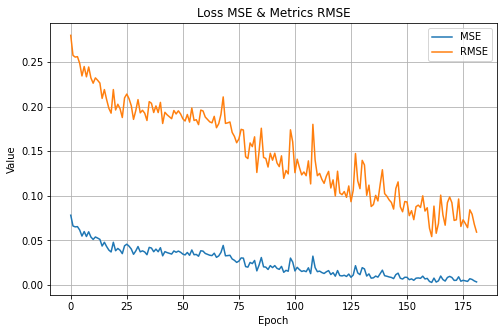

In [138]:
best_history_model = globals()[best_history]
# grafik loss function MSE
plt.figure(figsize=(8,5))
plt.plot(best_history_model.history['loss'], label='MSE')
plt.plot(best_history_model.history['root_mean_squared_error'], label='RMSE')
plt.title('Loss MSE & Metrics RMSE')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

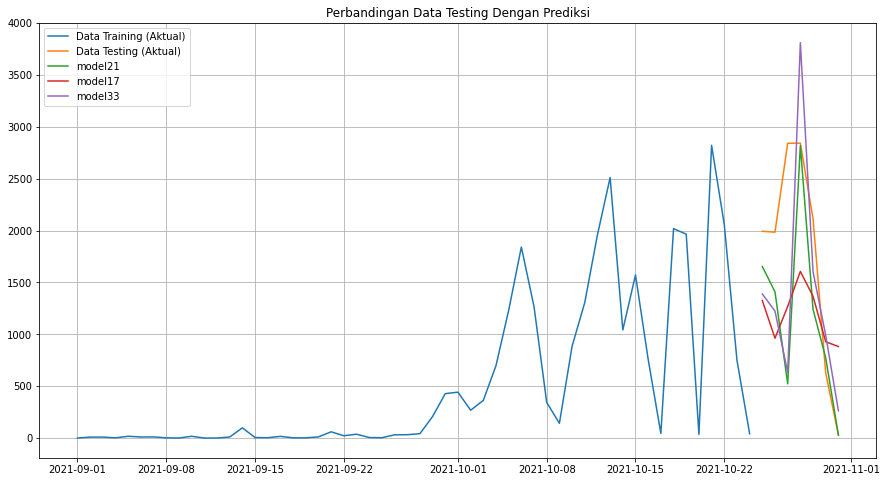

In [92]:
plt.figure(figsize=(15,8))
plt.grid()
plt.title("Perbandingan Data Testing Dengan Prediksi")
plt.plot(train['Jumlah'], label="Data Training (Aktual)")
plt.plot(test['Jumlah'], label="Data Testing (Aktual)")
for i in range(3):
  plt.plot(test[test.columns[rootmin[i]+2]], label = test.columns[rootmin[i]+2])
plt.legend(loc="upper left")
plt.show()

In [93]:
pred_list = []
batch = test[-time_steps:][['scaled']].values.reshape((1, time_steps, 1))
prediksi = 7
for i in range(prediksi):   
    pred_list.append(globals()[best_model].predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [94]:
add_dates = [df_final.index[-1] + DateOffset(days=x) for x in range(0,prediksi+1) ]
df_prediksi = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=add_dates[1:],
                          columns=['Prediksi'])
df_prediksi

,Prediksi
2021-11-01,715.793214
2021-11-02,1170.089543
2021-11-03,1445.007874
2021-11-04,2849.400251
2021-11-05,1732.756458
2021-11-06,558.763090
2021-11-07,1081.554515


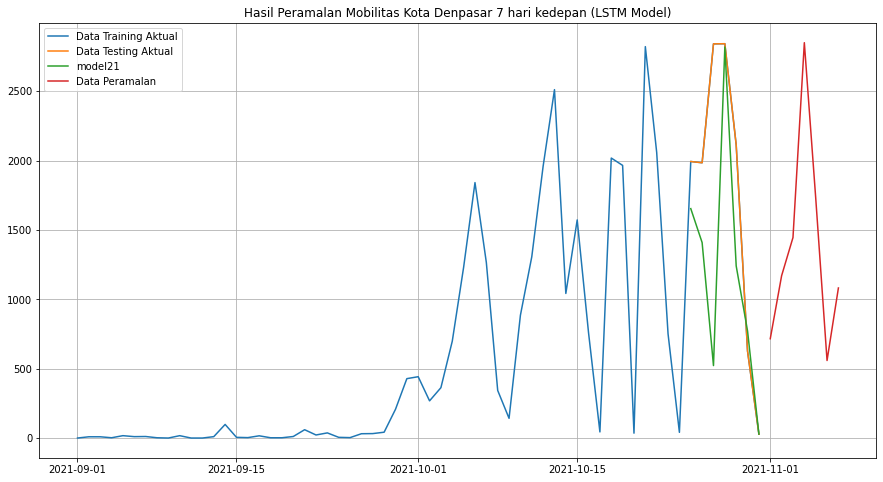

In [95]:
plt.figure(figsize=(15,8))
plt.grid()
plt.title("Hasil Peramalan Mobilitas Kota Denpasar 7 hari kedepan (LSTM Model)")
plt.plot(df_final['Jumlah'], label="Data Training Aktual")
plt.plot(test['Jumlah'], label="Data Testing Aktual")
plt.plot(test[test.columns[rootmin[0]+2]], label = test.columns[rootmin[0]+2])
plt.plot(df_prediksi['Prediksi'], label="Data Peramalan")
plt.legend(loc="upper left")

In [96]:
globals()[best_model].save("/content/drive/MyDrive/Dataset/Hasil/best_model.h5")

In [97]:
weight_layer1 = pd.DataFrame(globals()[best_model].layers[0].get_weights()[0])
weight_layer1_1 = pd.DataFrame(globals()[best_model].layers[0].get_weights()[1])
bias_layer1 = pd.DataFrame(globals()[best_model].layers[0].get_weights()[2])

In [98]:
weight_layer2 = pd.DataFrame(globals()[best_model].layers[2].get_weights()[0])
weight_layer2_1 = pd.DataFrame(globals()[best_model].layers[2].get_weights()[1])
bias_layer2 = pd.DataFrame(globals()[best_model].layers[2].get_weights()[2])

In [99]:
weight_layer3 = pd.DataFrame(globals()[best_model].layers[4].get_weights()[0])
weight_layer3_1 = pd.DataFrame(globals()[best_model].layers[4].get_weights()[1])
bias_layer3 = pd.DataFrame(globals()[best_model].layers[4].get_weights()[2])

In [100]:
out_weight_layer = pd.DataFrame(globals()[best_model].layers[6].get_weights()[0])
out_bias_layer = pd.DataFrame(globals()[best_model].layers[6].get_weights()[1])

In [101]:
weight_layer1.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer1.xlsx")
weight_layer1_1.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer1_1.xlsx")
bias_layer1.to_excel("/content/drive/MyDrive/Dataset/Hasil/bias_layer1.xlsx")
weight_layer2.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer2.xlsx")
weight_layer2_1.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer2_1.xlsx")
bias_layer2.to_excel("/content/drive/MyDrive/Dataset/Hasil/bias_layer2.xlsx")
weight_layer3.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer3.xlsx")
weight_layer3_1.to_excel("/content/drive/MyDrive/Dataset/Hasil/weight_layer3_1.xlsx")
bias_layer3.to_excel("/content/drive/MyDrive/Dataset/Hasil/bias_layer3.xlsx")
out_weight_layer.to_excel("/content/drive/MyDrive/Dataset/Hasil/out_weight_layer.xlsx")
out_bias_layer.to_excel("/content/drive/MyDrive/Dataset/Hasil/out_bias_layer.xlsx")

In [102]:
test.to_excel('/content/drive/MyDrive/Dataset/Hasil/test.xlsx')
train.to_excel('/content/drive/MyDrive/Dataset/Hasil/train.xlsx')

In [103]:
df_prediksi.to_excel('/content/drive/MyDrive/Dataset/Hasil/hasil-peramalan.xlsx')

In [133]:
globals()[best_model].get_weights()

[array([[-3.34831960e-02, -6.21701311e-03, -1.06750000e-02,
          7.41935149e-02, -3.84216139e-04,  1.23827249e-01,
          1.77204013e-01,  4.00240682e-02,  7.11802989e-02,
          3.55913527e-02,  7.34377280e-02, -4.08127625e-03,
         -3.28857312e-03,  1.94897484e-02,  1.75905585e-01,
          6.02773651e-02, -9.57061201e-02,  4.91507910e-02,
         -8.46838802e-02,  1.03072613e-01,  8.17630906e-03,
          2.24071126e-02, -1.06928097e-02,  2.01250594e-02,
          2.14274973e-01,  8.29700008e-02,  2.36962773e-02,
         -8.18459466e-02,  2.11288154e-01,  8.43099784e-03,
         -1.15516365e-01, -5.10550290e-02,  1.21591493e-01,
          7.26417676e-02, -1.24435630e-02,  3.52885276e-02,
         -1.02901477e-02, -3.23623449e-01, -3.47456289e-03,
         -6.92934915e-02,  1.35223687e-01, -3.12078539e-02,
          1.11729428e-01, -2.58210506e-02, -4.32599559e-02,
          1.08186692e-01,  6.06148802e-02,  1.09760866e-01,
         -5.22931712e-03,  4.93359789e-0

In [134]:
root.to_excel("/content/drive/MyDrive/Dataset/Hasil/rmse.xlsx")